Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Path Finding Algorithms

Path-finding algorithms are a category of graph algorithms that focus on finding a path, a connected set of nodes and edges, between two or more sets of nodes within a graph. They are often used to find available or optimized paths based on the existence, quantity, or quality of the paths and the values of properties along those paths.

By efficiently determining the best route between two nodes, path-finding algorithms enable you to model real-world systems like roads or social networks as interconnected nodes and edges. Finding the shortest paths between various points is crucial in applications like route planning for GPS systems, logistics optimization, and even in solving complex problems in fields like biology or engineering.

## Supported Algorithms

Neptune Analytics supports the following path finding algorithms, each of which has a few variants:

* [Breadth First Search (BFS)](#Breadth-First-Search) -  Breadth first search is an algorithm for searching a graph by exploring all the neighbor nodes in the present depth prior to moving to the nodes at the next depth level.
* [Single Source Shortest Path (SSSP)](#Single-Source-Shortest-Path) -  Single source shortest path is an algorithm that finds the shortest paths from a single source vertex to all other vertices in a weighted graph.

## Loading Data
The first step in most projects is to load data to use for analysis.  For demonstration purposes, we have provided a set of datasets that can be used to demonstrate the features and functionality of Neptune Analytics. 

The cell below makes it easy to load the `air-routes` data into your graph.  The `air-routes` dataset we will be loading in this notebook is supplied as part of the [Practical Gremlin](https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html#air) book.

The `air-route`'s graph contains several vertex types that are specified using labels. The most common ones being `airport` and `country`. There are also nodes for each of the seven continents (`continent`) and a single `version` vertex that I provided as a way to test which version of the graph you are using.

Routes between airports are modeled as edges. These edges carry the `route` label and include the distance between the two connected airport vertices as a property called `dist`. Connections between countries and airports are modelled using an edge with a `contains` label.

Each `airport` vertex has many properties associated with it giving various details about that airport including its IATA and ICAO codes, its description, the city it is in and its geographic location. A full data model of the `air-route`s graph is below.

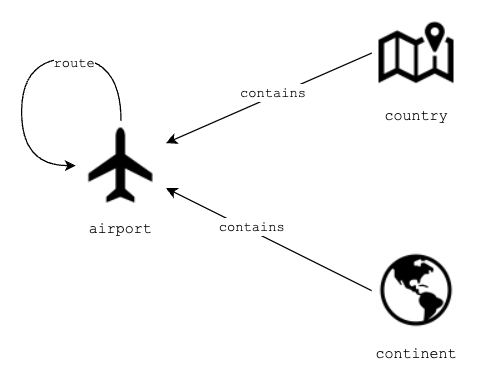

To load this dataset, run the two cells below.  This first cell will setup a few python variables using the configuration parameters of this Neptune Notebook.  The second cell will use Neptune Analytics batch load feature to load the data from the provided S3 bucket.  

**Note:** You only need to do this once. If you have already loaded the data previously you do not need to load it again.



In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

s3_bucket = f"s3://aws-neptune-customer-samples-{config.aws_region}/sample-datasets/gremlin/air-routes/"
region = config.aws_region

In [ ]:
%%oc 

CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})

After running the load you will see a summary of the data that was loaded into the graph. 

Now let's take a look at how we can execute algorithms and variants.

## Breadth First Search

 Here are some common uses of the breadth-first search (BFS) algorithm:

- Check for connectivity in graphs - BFS can be used to check if there is a path between two nodes or determine if a graph is connected by exploring all reachable nodes from a starting point.

- Finding the minimum number of steps between two nodes. Since BFS explores neighbors first, the first path found to the target node will have the fewest number of edges traversed. 

- Finding all nodes at a given distance from a source node - BFS systematically explores all nodes that are 1, 2, 3 hops away and so on, allowing you to collect nodes by their distance.

- Solving problems with hierarchical structures - BFS can traverse tree-like structures level-by-level from root to leaves.

In summary, problems that require level-order/distance-based exploration or verifying connectivity in graphs is a good match for BFS.

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a best practice</i></b></summary>
  
Every source node passed in initiates its own execution of the algorithm. For example, consider the following query:
    
```
MATCH (a:airport {region: 'US-WA'})
CALL neptune.algo.bfs(a, {maxDepth: 1})
YIELD node
RETURN node
```
In this example, the `bfs` algorithm would be executed 9 times, one for each `airport` in the region `US-WA`.  When large numbers of nodes are returned from the `MATCH` clause, the performance of the query will be impacted.
    
It is best practice to limit the number of source nodes as much as possible.    
</details>
</div>


### `bfs`
Standard breadth-first search (BFS) is an algorithm for finding nodes from a starting node or nodes in a graph in breadth-first order.  It returns the source node or nodes that it started from, and a list of all the nodes it visited during the search, in breadth-first order.  




Using our air routes data, let's see how we can apply BFS to retrieve all airports within 3 flights of the `SEA` airport.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.bfs(a, {maxDepth: 3})
YIELD node
RETURN node ORDER BY id(node)

As we see, BFS was able to quickly finding all these connected airports.  

Using openCypher, we can write a query that returns the same information, as shown in the cell below.  Run that cell now and compare the execution times to the algorithmic approach.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})-[*3]->(node)
RETURN DISTINCT(node) ORDER BY id(node)

As we see, the same results were returned by both queries, however even on the small size of our air routes dataset, the performance of the algorithm was several times better than that of a pure openCypher query.  

### `bfs.parents`

The `parents` variant of breadth-first search is an algorithm for finding nodes from a starting node or vertices in breadth-first order and then returning both the node and the associated parent.

Here are some common uses of the `bfs.parents` algorithm:

- Finding disconnected components in a graph. Run BFS from each node and store the parent. Nodes with the same parent are in the same connected component.

- Level order traversal of a tree. Store the parent in BFS to implicitly represent the tree structure and traverse level-by-level. 

- Detecting cycles in a graph. If at any point the parent of the current node is already in the queue, we have found a back edge indicating a cycle.

- Topological sorting of DAGs (directed acyclic graphs). Run BFS and store parents. Output nodes in order of finish time for a valid topological sort.

- Social network connectivity. Run BFS from each node to find how many "hops" away other nodes are in a social network graph.

So in summary, the parents information from BFS is useful anytime you need to reconstruct paths/relationships or do topological traversals of graphs and trees.

Let's use the same query from before and see how the output changes when we use `bfs.parents`.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.bfs.parents(a, {maxDepth: 3})
YIELD node, parent
RETURN node.code, parent ORDER BY id(node)

With the `parents` variant we see that we not only return the `node` but the associated `parent`.

### `bfs.levels`

The `levels` variant of breadth-first search is an algorithm for searching nodes from a starting node or nodes in breadth-first order. From there it performs a breadth-first search and records the hop level from the starting node of each node that it finds.

It returns a key column of nodes, and a value column containing the level values of those key nodes.

The level of a source node is 0.

 Here are some common uses of a breadth-first search (BFS) levels algorithm:

- Level ordering of nodes. BFS provides a natural level ordering by distance from the source node. This can be useful for laying out hierarchical tree structures. 

- Determining if a graph is bipartite. A graph is bipartite if the nodes can be divided into two independent sets such that no two nodes within the same set are adjacent. BFS can be used to test this property.

- Collecting all nodes at a given distance from a source. BFS levels allow you to easily retrieve all nodes that are k edges away from the starting node. 

- Traversing file system trees or directory structures. BFS allows traversing the hierarchy in a level-by-level, breadth-first manner.

So in summary, any problem that requires finding all nodes at a given distance or doing a level-ordered traversal is a good match for BFS levels.

Let's use the same query from before and see how the output changes when we use `bfs.levels`.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.bfs.levels(a, {maxDepth: 3})
YIELD node, level
RETURN node.code, level ORDER BY id(node)

A very common way you may combine the `bfs.levels` query with openCypher would be to take the output from a query, as shown above, and group this by the level, in order to provide a level wise set of nodes, which is commonly used for representing tree type structures in data, such as organizational hierarchies of employees, supply chain routing, or cloud resource management.

In our scenario, this would represent the airports that you can get to on a specific number of flights.  Run the query below to see the results.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.bfs.levels(a, {maxDepth: 3})
YIELD node, level
RETURN level, collect(node.code) ORDER BY level

## Single Source Shortest Path
Single Source Shortest Path (SSSP) algorithms compute the shortest path between a source node and all reachable nodes within the graph.

 Some common uses of the Single-Source Shortest Path (SSSP) algorithm include:

- Route planning - Finding the shortest route between two locations on a road network or public transportation system. This is a core capability for navigation and routing apps.

- Network routing - Computing the optimal path for data packets to travel across networks like the internet. Routing algorithms in networking use SSSP.

- Logistics/supply chain optimization - Determining the most efficient delivery routes for transporting goods between locations in a supply chain or distribution network. 

- Traffic modeling - Analyzing traffic patterns and congestion levels by computing shortest paths between origins and destinations in a transportation model.

- Social network analysis - Measuring distances and degrees of separation between nodes/people in social networks like friend networks. 

- Map generation - Creating distance-based maps by computing distances from a starting point to all other reachable locations on a graph-based map.

- Robot path planning - Allowing robots to navigate optimally between points in an environment based on distance calculations.

- Network centrality analysis - Quantifying the importance of nodes in a network based on their distance/closeness to other nodes using SSSP.

So in summary, any application that requires finding optimal paths or distances between points in a graph-based system can benefit from using the SSSP algorithm.

### `sssp.bellmanFord`

This algorithm uses the [Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm) to compute the SSSP from the specified source vertex to all reachable vertices in a weighted graph.  

 Here are some common uses and applications of the Bellman-Ford algorithm:

- Finding shortest paths in graphs: The Bellman-Ford algorithm can be used to find the shortest paths from a single source vertex to all other vertices in a weighted graph. This is its most classic application.

- Routing in computer networks: It can be used for routing in networks where link costs can change over time, allowing for faster re-routing than Dijkstra's algorithm when link costs decrease.

- Approximating all-pairs shortest paths: By running Bellman-Ford from each vertex, you can approximate the all-pairs shortest path problem, which is useful for sparse graphs.

So in summary, any application that requires shortest path calculations in graphs with edge weights, dynamic networks, or cycle detection could benefit from using the Bellman-Ford algorithm.

Neptune Analytics implements the algorithm such that:

- Positive edge weights must be provided using the `edgeWeightProperty` field
- Negative edge weights are not supported.
- The traversal direction cannot be set to both.

To continue using our air-routes examples from above, let's use SSSP to find the shortest to all the airports we can fly to from `SEA` using the `dist` property on the `route` edge as our weight.  Let's also order them by the total distance traveled in descending order.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.sssp.bellmanFord(a, {edgeWeightProperty: 'dist', edgeWeightType: 'int', edgeLabels: ['route']})
YIELD node, distance
RETURN node.code, distance, node.desc ORDER BY distance DESC

Looking at the results, we see that we were able to quickly find that `BZZ - RAF Brize Norton` is the farthest distance we could fly from Seattle, with a total distance of ~16000 miles.

### `sssp.bellmanFord.parents`

The `sssp.bellmanFord.parents` variant is similar to the `bfs.parents` variant will return parent node of the reachable node.

Let's take our example from above and see what the results look like when we include the `parent`.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.sssp.bellmanFord.parents(a, {edgeWeightProperty: 'dist', edgeWeightType: 'int', edgeLabels: ['route']})
YIELD node, distance, parent
RETURN node.code, distance, parent.code ORDER BY distance DESC

### `sssp.deltaStepping`

This algorithm uses the [Delta Stepping algorithm](https://en.wikipedia.org/wiki/Parallel_single-source_shortest_path_algorithm#Delta_stepping_algorithm) to compute the SSSP from the specified source vertex to all reachable vertices in a weighted graph.  

Some key uses and applications of the SSSP Delta Stepping algorithm include:

- Network routing: Finding the shortest paths in a network is important for routing protocols in computer networks. SSSP Delta Stepping can efficiently calculate optimal routes.

- Transportation modeling: Modeling transportation and logistics networks to find optimal routes for vehicles, shipments, etc. SSSP Delta Stepping scales well to large transportation graphs. 

- Social network analysis: Analyzing the structure of social networks by finding the closest connections between nodes. This informs things like influence propagation and community detection.

- Map routing: Finding driving/walking directions by computing shortest paths on road/path networks

So in summary, any application that requires efficiently solving the SSSP problem on large graphs can benefit from the Delta Stepping approach.

Neptune Analytics implements the algorithm such that:

- Positive edge weights must be provided using the edgeWeightProperty field
- Negative edge weights are not supported.
- The traversal direction cannot be set to both.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.sssp.deltaStepping(a, {edgeWeightProperty: 'dist', edgeWeightType: 'int', edgeLabels: ['route']})
YIELD node, distance
RETURN node.code, distance, node.desc ORDER BY distance DESC

### `sssp.deltaStepping.parents`

As with `bfs.parents` and `sssp.bellmanFord.parent`, the `sssp.deltaStepping.parents` variant will return parent node of the reachable node.

Let's take our example from above and see what the results look like when we include the parent.

In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.sssp.deltaStepping.parents(a, {edgeWeightProperty: 'dist', edgeWeightType: 'int', edgeLabels: ['route']})
YIELD node, distance, parent
RETURN node.code, distance, parent.code ORDER BY distance DESC

### Top K Single Source Sourtest Path

Neptune Analytics also provides an SSSP implementation that allows you to specify a per hop limit, as well as weighting function to calculate an optimized shortest path.

The `topksssp algorithm` finds the single-source weighted shortest paths from a source node to its neighbors out to the distance specified by maxDepth. It accumulates the path lengths using the edge weights along the paths and then returns a sorted list of the shortest paths.  This is very useful in optimizing many situations such as supply chain optimization problems, mapping, applications, or social network analysis.

Let's take a look at this algorithm using a slight variation of the question we have been using so far.  Let's use `topksssp` to find the shortest to all the airports we can fly to from SEA using the `dist` property on the `route` edge as our weight except that we will add the following additional filters:

- We will go to a max depth of 3
- For the first hop we want only the 10 closest airports
- For the second hop we want only the 100 closest airports
- For the third hop we want only the 1000 closest airports


In [ ]:
%%oc

MATCH (a:airport {code: 'SEA'})
CALL neptune.algo.topksssp(a, {hopCount: 3, perHopLimits: [10, 100, 1000], 
                               edgeWeightProperty: 'dist', edgeWeightType: 'int', edgeLabels: ['route'],
                               costFunction: 'min'})
YIELD node, distance
RETURN node.code, distance, node.desc ORDER BY distance DESC

## Next Steps
In this notebook, we have demonstrated how to use the path finding algorithms provided by Neptune Analytics.  If you are interested in the other types of algorithms offered please look at the other notebooks available:

* [Centrality algorithms](./03-Centrality-Algorithms.ipynb)

* [Community detection/clustering algorithms](./04-Community-Detection-Algorithms.ipynb)

* [Similarity algorithms](./05-Similarity-Algorithms.ipynb)

* [Vector Similarity algorithms](./06-Vector-Similarity-Algorithms.ipynb)